In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Flow Matching

### A Different Perspective on Generative Models with ODEs: Continuous Normalizing Flows (CNFs)

####  About ODEs, Again

Previously, we discussed how generative models could be defined through stochastic differential equations (SDEs) or, equivalently, corresponding probability flow ordinary differential equations (PF-ODEs). We showed that by solving SDEs/ODEs using a numerical solver like backward Euler's method, we obtain an iterative generative procedure of turning noise into data. 

However, there is a question of whether we need to first formulate an SDE and its PF-ODE equivalent or maybe we can take any ODE to define a generative model. 

**We recall the definition of an ODE:**

$$
\frac{d\mathbf{x}_t}{dt} = \mathbf{v}(\mathbf{x}_t, t),
$$

where the vector field, $\mathbf{v}(\mathbf{x}_t, t)$, defines the dynamics. Parameterizing the vector field with a neural network with weights $\theta$, $\mathbf{v}_{\theta}(\mathbf{x}_t, t)$, leads to a so-called neural ODE [26]. 

If we denote by $\mathbf{x}_0$ the initial condition for this neural ODE, e.g., noise, then by solving it, i.e., integrating over time $t$, we get the output (e.g., data):

$$
\mathbf{x}_1 = \mathbf{x}_0 + \int_{0}^{1} \mathbf{v}_{\theta}(\mathbf{x}_t, t) dt.
$$

So far so good, but there is (almost) nothing new compared to score-based generative models where we match scores instead of distributions (i.e., an empirical distribution to a model). Could we formulate a likelihood-based training? 

The short answer is: Yes. Is it easy? Again, the short answer is no. But let us look into both answers more in detail.

#### From the Continuity Equation (Conservation of Mass) to the Instantaneous Change of Variables

Again, sampling from an ODE, namely, integrating from $t = 0$ to $t = 1$ is not difficult once we have a model of the vector field. We can use Euler's method for that (or any other numerical solver). However, obtaining the model is problematic if we prefer Fitting a data distribution to a distribution induced by $\mathbf{v}_{\theta}(\mathbf{x}, t)$. After all, starting with a known distribution $\mathbf{x}_0 \sim \pi(\mathbf{x})$ like standard Gaussian and then solving the ODE yield another distribution! We can express this induced distribution analytically using the continuity equation.

Here comes some math (and even physics!), so buckle up and let us dive in. Imagine for a second that probability is a mass (I always think of clay, but it could be water if you prefer), something we can touch with our fingers. Now, let us visualize a pipe of the same cross-section volume across its length in which our mass (e.g., water) flows. At each moment of time, we have some flux of this mass, $\mathbf{f}_t$, i.e., our (probability) mass is moved according to the vector field (or velocity), $\mathbf{f}_t(\mathbf{x}_t) = p_t(\mathbf{x}_t)\mathbf{v}(\mathbf{x}_t, t)$. 

Since we talk about probability mass (or water flowing through the pipe of the same volume of cross sections everywhere), the mass is conserved, i.e., no new mass (water) (dis)appears (no leaking or pouring in). 

Mathematically, it means that the change of the mass $\frac{\partial p_t(\mathbf{x}_t)}{\partial t}$ plus the change of the flux volume in all directions (a.k.a. the divergence of the flux) is constant (i.e., the mass is conserved):

$$
\frac{\partial p_t(\mathbf{x}_t)}{\partial t} + \text{div}(p_t(\mathbf{x}_t)\mathbf{v}(\mathbf{x}_t, t)) = 0, \quad (9.40)
$$

where $\text{div}(\cdot)$ is the divergence defined as follows:

$$
\text{div}(\mathbf{V}(x_1, ..., x_D)) = \sum_{d=1}^{D} \frac{\partial V_d(x_1,...,x_D)}{\partial x_d},
$$

i.e., the sum of first derivatives of $\mathbf{V}$ over all variables separately.

**A Side Note:**

The trace of the Jacobian matrix is the divergence of the vector field! For a two-dimensional space and a vector field $\mathbf{V}(x_1, x_2)$,

$$
\text{div}(\mathbf{V}(x_1, x_2)) = \frac{\partial V_1(x_1,x_2)}{\partial x_1} + \frac{\partial V_2(x_1,x_2)}{\partial x_2} = \text{Tr} \begin{pmatrix}
\frac{\partial V_1(x_1,x_2)}{\partial x_1} & \frac{\partial V_1(x_1,x_2)}{\partial x_2} \\
\frac{\partial V_2(x_1,x_2)}{\partial x_1} & \frac{\partial V_2(x_1,x_2)}{\partial x_2}
\end{pmatrix},
$$

where $\text{Tr}(A) = \sum_{i} A_{ii}$ is the trace of a matrix $A$. 

It turns out that applying identities of vector calculus and the properties of the divergence allows us to write the continuity equation using the logarithm of the probability distribution (a.k.a. the instantaneous change of variables [26]):

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} + \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right) = 0. \quad (9.41)
$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the ODE solver (using a simple Euler method for illustration)
def ode_solve(func, x0, t, dt=0.01):
    """
    Solves the ODE dx/dt = func(x, t) using Euler's method.

    Args:
        func: The function defining the ODE.
        x0: The initial condition.
        t: The time interval (e.g., torch.linspace(0, 1, 100)).
        dt: The step size for Euler's method.

    Returns:
        A tensor containing the solution of the ODE at each time step.
    """
    x = x0.clone()
    solution = [x0]
    for i in range(len(t) - 1):
        x = x + dt * func(x, t[i])
        solution.append(x)
    return torch.stack(solution)

# Define the neural network for the vector field
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )

    def forward(self, x, t):
        return self.net(x)

# Define the CNF model
class CNF(nn.Module):
    def __init__(self, dim):
        super(CNF, self).__init__()
        self.ode_func = ODEFunc(dim)

    def forward(self, x0, t):
        return ode_solve(self.ode_func, x0, t)

# Example usage
dim = 2  # Dimensionality of the data
cnf = CNF(dim)

# Sample initial conditions (e.g., from a standard Gaussian)
x0 = torch.randn(100, dim) 

# Define time points
t = torch.linspace(0, 1, 100)

# Generate samples
x_samples = cnf(x0, t)[-1]  # Take the final time step

# Define a loss function (e.g., negative log-likelihood)
# ... (Implementation depends on the specific data distribution)

# Train the CNF model using an optimizer
optimizer = optim.Adam(cnf.parameters(), lr=1e-3)
# ... (Training loop)

# Note: This is a simplified example. 
# - You'll need to implement the loss function and training loop.
# - Consider using more sophisticated ODE solvers (e.g., Runge-Kutta).
# - Explore different neural network architectures for the vector field.

Epoch: 0, Loss: 0.9208796620368958
Epoch: 100, Loss: 0.08247531205415726
Epoch: 200, Loss: 0.026448579505085945
Epoch: 300, Loss: 0.01268110889941454
Epoch: 400, Loss: 0.007367204874753952
Epoch: 500, Loss: 0.004787792451679707
Epoch: 600, Loss: 0.003347873454913497
Epoch: 700, Loss: 0.0024645954836159945
Epoch: 800, Loss: 0.0018847165629267693
Epoch: 900, Loss: 0.0014840115327388048


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

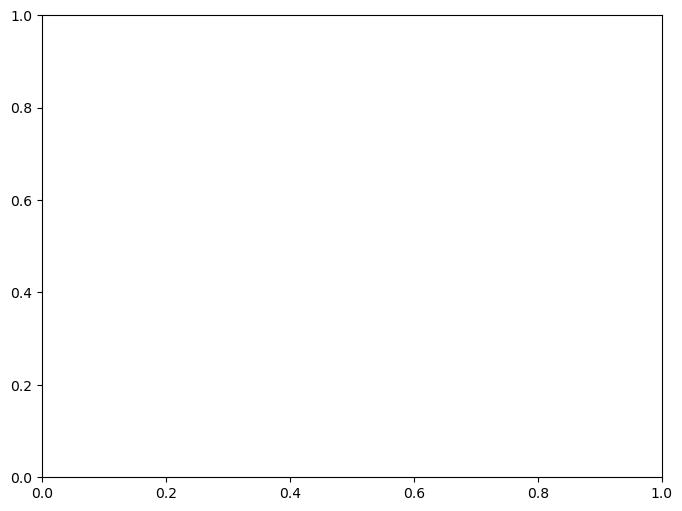

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the ODE solver (using a simple Euler method for illustration)
def ode_solve(func, x0, t, dt=0.01):
    """
    Solves the ODE dx/dt = func(x, t) using Euler's method.

    Args:
        func: The function defining the ODE.
        x0: The initial condition.
        t: The time interval (e.g., torch.linspace(0, 1, 100)).
        dt: The step size for Euler's method.

    Returns:
        A tensor containing the solution of the ODE at each time step.
    """
    x = x0.clone()
    solution = [x0]
    for i in range(len(t) - 1):
        x = x + dt * func(x, t[i])
        solution.append(x)
    return torch.stack(solution)

# Define the neural network for the vector field
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )

    def forward(self, x, t):
        return self.net(x)

# Define the CNF model
class CNF(nn.Module):
    def __init__(self, dim):
        super(CNF, self).__init__()
        self.ode_func = ODEFunc(dim)

    def forward(self, x0, t):
        return ode_solve(self.ode_func, x0, t)

# Define the loss function (using a simple example)
def loss_fn(x_samples):
    # Replace this with your actual loss function
    # Here, we use the mean squared error as an example
    return torch.mean(x_samples**2)

# Training parameters
dim = 2  # Dimensionality of the data
num_epochs = 1000
learning_rate = 1e-3

# Initialize the CNF model
cnf = CNF(dim)
optimizer = optim.Adam(cnf.parameters(), lr=learning_rate)

# Sample initial conditions (e.g., from a standard Gaussian)
x0 = torch.randn(100, dim) 

# Define time points
t = torch.linspace(0, 1, 100)

# Training loop
for epoch in range(num_epochs):
    # Generate samples
    x_samples = cnf(x0, t)[-1]  # Take the final time step

    # Calculate loss
    loss = loss_fn(x_samples)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Generate samples after training
x_samples_final = cnf(x0, t)[-1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x_samples_final[:, 0], x_samples_final[:, 1], label='Generated Samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Generated Samples from CNF')
plt.legend()
plt.show()

In [3]:
import math
import random

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def tanh(x):
    return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.biases1 = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.weights2 = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.biases2 = [random.uniform(-1, 1) for _ in range(output_size)]

    def forward(self, inputs):
        hidden_layer_inputs = [sum(x * w for x, w in zip(inputs, weights)) + bias 
                              for weights, bias in zip(self.weights1, self.biases1)]
        hidden_layer_outputs = [tanh(x) for x in hidden_layer_inputs]

        output_layer_inputs = [sum(x * w for x, w in zip(hidden_layer_outputs, weights)) + bias 
                               for weights, bias in zip(self.weights2, self.biases2)]
        outputs = [sigmoid(x) for x in output_layer_inputs]
        return outputs

# --- SGBM Specifics (Simplified) ---

def score_function(model, x):
    # This is a simplified example. 
    # In a real SGBM, you would implement a more complex score function.
    # This example assumes a simple neural network for the score function.
    return model.forward(x) 

def sample_from_prior(dim):
    # Sample from a standard Gaussian prior
    return [random.gauss(0, 1) for _ in range(dim)]

def generate_sample(score_function, num_steps, step_size):
    x = sample_from_prior(dim) 
    for _ in range(num_steps):
        # Simplified Euler-Maruyama step
        noise = [random.gauss(0, 1) for _ in range(dim)] 
        score = score_function(x)
        x = [x_i + step_size * (score_i + noise_i) for x_i, score_i, noise_i in zip(x, score, noise)] 
    return x

# Example Usage
dim = 2  # Dimensionality of the data
num_steps = 100
step_size = 0.01

# Create a neural network for the score function
score_model = NeuralNetwork(dim, 10, dim) 

# Generate a sample
generated_sample = generate_sample(score_model.forward, num_steps, step_size)
print("Generated Sample:", generated_sample)



Generated Sample: [-0.6341038033481257, 0.5815479984358901]


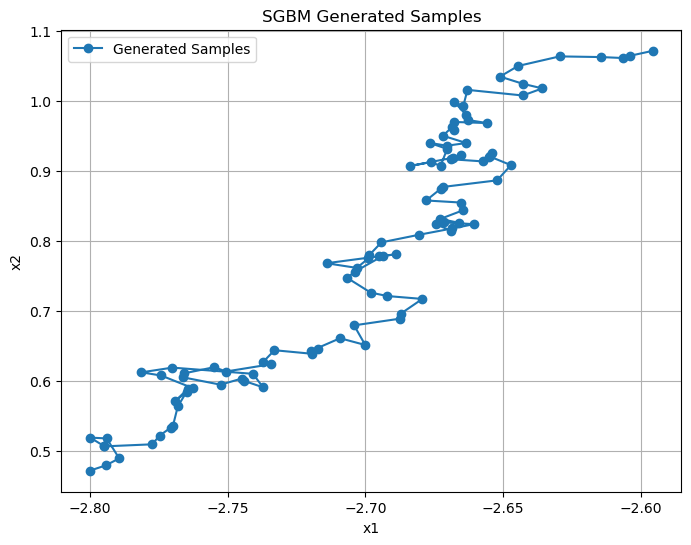

In [4]:
import math
import random
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def tanh(x):
    return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.biases1 = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.weights2 = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.biases2 = [random.uniform(-1, 1) for _ in range(output_size)]

    def forward(self, inputs):
        hidden_layer_inputs = [sum(x * w for x, w in zip(inputs, weights)) + bias 
                              for weights, bias in zip(self.weights1, self.biases1)]
        hidden_layer_outputs = [tanh(x) for x in hidden_layer_inputs]

        output_layer_inputs = [sum(x * w for x, w in zip(hidden_layer_outputs, weights)) + bias 
                               for weights, bias in zip(self.weights2, self.biases2)]
        outputs = [sigmoid(x) for x in output_layer_inputs]
        return outputs

# --- SGBM Specifics (Simplified) ---

def score_function(model, x):
    # This is a simplified example. 
    # In a real SGBM, you would implement a more complex score function.
    # This example assumes a simple neural network for the score function.
    return model.forward(x) 

def sample_from_prior(dim):
    # Sample from a standard Gaussian prior
    return [random.gauss(0, 1) for _ in range(dim)]

def generate_sample(score_function, num_steps, step_size, dim):
    x = sample_from_prior(dim) 
    samples = [x]  # Store samples for plotting
    for _ in range(num_steps):
        # Simplified Euler-Maruyama step
        noise = [random.gauss(0, 1) for _ in range(dim)] 
        score = score_function(x)
        x = [x_i + step_size * (score_i + noise_i) for x_i, score_i, noise_i in zip(x, score, noise)] 
        samples.append(x)
    return samples

# Example Usage
dim = 2  # Dimensionality of the data
num_steps = 100
step_size = 0.01

# Create a neural network for the score function
score_model = NeuralNetwork(dim, 10, dim) 

# Generate samples
generated_samples = generate_sample(score_model.forward, num_steps, step_size, dim)

# Extract x and y coordinates for plotting
x_coords = [sample[0] for sample in generated_samples]
y_coords = [sample[1] for sample in generated_samples]

# Plot the samples
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', label='Generated Samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SGBM Generated Samples')
plt.legend()
plt.grid(True)
plt.show()

I know you, my curious reader, you dislike being told about something without proof. It is a side note, so if you do not have time for it, just skip it. But I find this pretty cool and it will be also helpful in our further discussion. 

Ok, so what do we need? 

First, a general property:

$$
\frac{\partial \ln p_t}{\partial t} = \frac{1}{p_t} \frac{\partial p_t}{\partial t}, 
$$

or equivalently,

$$
p_t \frac{\partial \ln p_t}{\partial t} = \frac{\partial p_t}{\partial t}.
$$

Second, we have:

$$
\text{div}(p_t \mathbf{v}) = \langle \nabla_x p_t, \mathbf{v} \rangle + p_t \text{div}(\mathbf{v}); 
$$

hence, 

$$
\frac{1}{p_t} \text{div}(p_t \mathbf{v}) = \langle \nabla_x \ln p_t, \mathbf{v} \rangle + \text{div}(\mathbf{v}).
$$

Third, we saw already that the divergence of the vector field equals its trace:

$$
\text{div}(\mathbf{v}) = \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right).
$$

Now, we can plug these three facts into the continuity equation:

$$
\frac{\partial p_t(\mathbf{x}_t)}{\partial t} + \text{div}(p_t(\mathbf{x}_t)\mathbf{v}(\mathbf{x}_t, t)) = 0 \quad (9.42)
$$

$$
\frac{1}{p_t(\mathbf{x}_t)} \frac{\partial p_t(\mathbf{x}_t)}{\partial t} + \frac{1}{p_t(\mathbf{x}_t)} \text{div}(p_t(\mathbf{x}_t)\mathbf{v}(\mathbf{x}_t, t)) = 0 \quad (9.43)
$$

$$
\frac{\partial \ln p_t(\mathbf{x}_t)}{\partial t} + \langle \nabla_x \ln p_t, \mathbf{v} \rangle + \text{div}(\mathbf{v}(\mathbf{x}_t, t)) = 0 \quad (9.44)
$$

$$
\frac{\partial \ln p_t(\mathbf{x}_t)}{\partial t} = - \langle \nabla_x \ln p_t, \mathbf{v} \rangle - \text{div}(\mathbf{v}(\mathbf{x}_t, t)) \quad (9.45)
$$

Next, calculating the total derivative of $\ln p_t(\mathbf{x}_t)$ and plugging in the above equation for $\langle \nabla_x \ln p_t, \mathbf{v} \rangle$, we get the following [30]:

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} = \frac{\partial \ln p(\mathbf{x}_t)}{\partial t} + \left\langle \nabla_x \ln p(\mathbf{x}_t), \frac{d\mathbf{x}_t}{dt} \right\rangle \quad (9.46)
$$

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} = \frac{\partial \ln p(\mathbf{x}_t)}{\partial t} + \left\langle \nabla_x \ln p(\mathbf{x}_t), \mathbf{v}(\mathbf{x}_t, t) \right\rangle \quad (9.47)
$$

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} = \frac{\partial \ln p(\mathbf{x}_t)}{\partial t} + \left\langle \nabla_x \ln p(\mathbf{x}_t), \mathbf{v}(\mathbf{x}_t, t) \right\rangle \quad (9.48)
$$

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} = - \text{div}(\mathbf{v}(\mathbf{x}_t, t)) \quad (9.49)
$$

$$
\frac{d \ln p(\mathbf{x}_t)}{dt} = - \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right) \quad (9.50)
$$

Then, by integrating across time, we can compute the total change in log-density as follows:

$$
\int_0^1 \frac{d \ln p(\mathbf{x}_t)}{dt} dt = - \int_0^1 \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right) dt \quad (9.52)
$$

$$
\ln p(\mathbf{x}_1) - \ln \pi(\mathbf{x}_0) + \int_0^1 \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right) dt = 0 \quad (9.53)
$$

$$
\ln p(\mathbf{x}_1) = \ln \pi(\mathbf{x}_0) - \int_0^1 \text{Tr} \left( \frac{\partial \mathbf{v}(\mathbf{x}_t, t)}{\partial \mathbf{x}_t} \right) dt. \quad (9.54)
$$

Why do we bother to calculate everything as log-probabilities? Because the last line is a continuous version of the change of variables used for normalizing flows! Here, we have the integral over time of the trace of the Jacobian matrix instead of the sum of the log-determinants of the Jacobian matrix. Therefore, training neural ODEs is similar to training normalizing flows but with continuous time. As a result, neural ODEs in this context are referred to as continuous normalizing flows (CNFs).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE solver (using a simple Euler method for illustration)
def ode_solve(func, x0, t, dt=0.01):
    """
    Solves the ODE dx/dt = func(x, t) using Euler's method.

    Args:
        func: The function defining the ODE.
        x0: The initial condition.
        t: The time interval (e.g., torch.linspace(0, 1, 100)).
        dt: The step size for Euler's method.

    Returns:
        A tensor containing the solution of the ODE at each time step.
    """
    x = x0.clone()
    solution = [x0]
    for i in range(len(t) - 1):
        x = x + dt * func(x, t[i])
        solution.append(x)
    return torch.stack(solution)

# Define the neural network for the vector field
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )

    def forward(self, x, t):
        return self.net(x)

# Define the CNF model
class CNF(nn.Module):
    def __init__(self, dim):
        super(CNF, self).__init__()
        self.ode_func = ODEFunc(dim)

    def forward(self, x0, t):
        return ode_solve(self.ode_func, x0, t)

# Define the loss function (based on the CNF derivation)
def cnf_loss(cnf, x0, t):
    """
    Calculates the CNF loss based on the change of variables formula.

    Args:
        cnf: The CNF model.
        x0: Initial conditions.
        t: Time points.

    Returns:
        The CNF loss.
    """
    x_t = cnf(x0, t)
    # Simplified Jacobian calculation (for demonstration)
    # In practice, use automatic differentiation (torch.autograd)
    jacobian_trace = torch.zeros_like(x_t[:, 0]) 
    for i in range(x_t.shape[0]):
        jacobian_trace[i] = torch.trace(torch.autograd.functional.jacobian(lambda x: cnf(x, t[i]), x_t[i])) 
    log_det_jacobian = torch.sum(jacobian_trace, dim=0)  # Integrate over time (simplified)
    return -log_det_jacobian 

# Training parameters
dim = 2  # Dimensionality of the data
num_epochs = 1000
learning_rate = 1e-3

# Initialize the CNF model
cnf = CNF(dim)
optimizer = optim.Adam(cnf.parameters(), lr=learning_rate)

# Sample initial conditions (e.g., from a standard Gaussian)
x0 = torch.randn(100, dim) 

# Define time points
t = torch.linspace(0, 1, 100)

# Training loop
for epoch in range(num_epochs):
    # Generate samples
    x_t = cnf(x0, t) 

    # Calculate loss
    loss = cnf_loss(cnf, x0, t)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Generate samples after training
x_samples_final = cnf(x0, t)[-1]  # Take the final time step

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x_samples_final[:, 0], x_samples_final[:, 1], label='Generated Samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Generated Samples from CNF')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE solver (using a simple Euler method for illustration)
def ode_solve(func, x0, t, dt=0.01):
    """
    Solves the ODE dx/dt = func(x, t) using Euler's method.

    Args:
        func: The function defining the ODE.
        x0: The initial condition.
        t: The time interval (e.g., torch.linspace(0, 1, 100)).
        dt: The step size for Euler's method.

    Returns:
        A tensor containing the solution of the ODE at each time step.
    """
    x = x0.clone()
    solution = [x0]
    for i in range(len(t) - 1):
        x = x + dt * func(x, t[i])
        solution.append(x)
    return torch.stack(solution)

# Define the neural network for the vector field
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )

    def forward(self, x, t):
        return self.net(x)

# Define the CNF model
class CNF(nn.Module):
    def __init__(self, dim):
        super(CNF, self).__init__()
        self.ode_func = ODEFunc(dim)

    def forward(self, x0, t):
        return ode_solve(self.ode_func, x0, t)

# Define the loss function (based on the CNF derivation)
def cnf_loss(cnf, x0, t):
    """
    Calculates the CNF loss based on the change of variables formula.

    Args:
        cnf: The CNF model.
        x0: Initial conditions.
        t: Time points.

    Returns:
        The CNF loss.
    """
    x_t = cnf(x0, t)
    # Jacobian calculation using torch.autograd.grad
    jacobian = torch.autograd.grad(torch.sum(x_t, dim=0), x0)[0]  # Sum over time steps
    if len(x_t.shape) == 2:  # Check if x_t has two dimensions (batch size and feature dimension)
        x_t_flat = x_t.view(-1)  # Reshape into a single vector
    jacobian = torch.autograd.grad(torch.sum(x_t_flat), x0)[0]
    log_det_jacobian = torch.linalg.det(jacobian)  # Calculate determinant
    return -log_det_jacobian 

# Training parameters
dim = 2  # Dimensionality of the data
num_epochs = 1000
learning_rate = 1e-3

# Initialize the CNF model
cnf = CNF(dim)
optimizer = optim.Adam(cnf.parameters(), lr=learning_rate)

# Sample initial conditions (e.g., from a standard Gaussian)
x0 = torch.randn(100, dim) 

# Define time points
t = torch.linspace(0, 1, 100)

# Training loop
for epoch in range(num_epochs):
    # Generate samples
    x_t = cnf(x0, t) 

    # Calculate loss
    loss = cnf_loss(cnf, x0, t)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Generate samples after training
x_samples_final = cnf(x0, t)[-1]  # Take the final time step

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x_samples_final[:, 0], x_samples_final[:, 1], label='Generated Samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Generated Samples from CNF')
plt.show()

However, unlike in discrete time normalizing flows, we do not require invertibility of v; thus, for given datapoint x 
1
​
 , typically, we cannot simply invert the transformation to obtain x 
0
​
 . However, under pretty mild conditions (namely, v and its first derivative are Lipschitz continuous, e.g., for a neural net with Lipschitz continuous activation functions like SELU or SiLU, among others), we can uniquely solve the following problem [31]:

$$
x_0 = x_1 - \int_0^1 v_\theta(x_t, t) dt,
$$

with the following initial conditions:

$$
x_t|_{t=0} = x_{data}.
$$

where x 
1
​
  is a datapoint x 
data
​
  and the difference in log-probability is zero. Note that we solve the problem in the reverse order, namely, from data x 
1
​
  to noise x 
0
​
 .

Calculating the Log-Likelihood Function

To sum up, we need to carry out the following steps:

Take a datapoint x 
1
​
 =x 
data
​
 .
Solve the problem in (9.55) by applying a solver to find x 
0
​
  and keeping track of traces over time.
Calculate the log-likelihood by adding lnπ(x 
0
​
 ) to the sum of negative traces −∫ 
0
1
​
 Tr( 
∂x 
t
​
 
∂v 
θ
​
 (x 
t
​
 ,t)
​
 )dt.
Now, we can backpropagate through a solver and viola! Or really? What about the complexity of this whole procedure? At first glance, it seems very expensive.

9.4.1.4 Hutchinson’s Trace Estimator

If you remember correctly, my curious reader, the problem with normalizing flows was about calculating the log-determinant of the Jacobian matrix of size D×D, which in the general case costs O(D 
3
 ). Computing the trace requires O(D 
2
 ) since we need the sum of the diagonal, but each entry in the diagonal requires a separate forward propagation, thus, the quadratic complexity. It is better than in the discrete case, but there is another caveat: We need to backpropagate through a numerical solver! No free lunch, I am afraid.

Chen et al. [26] proposed to use the adjoint sensitivity method, which could be seen as a version of backpropagation with continuous time. Then, the neural ODE is trained by maximizing the log-likelihood lnp(x 
1
​
 ). However, it requires running the numerical method to solve the ODE and then backpropagating through it for each new datapoint. This is a very costly operation! As a result, we need to look for improvements to cut costs everywhere we can.

One trick we can apply is about calculating the trace. By utilizing Hutchinson’s trace estimator [31], the quadratic complexity is decreased to O(D), and it is relatively easy to calculate for any square matrix A, namely:

$$
Tr(A) = E_\epsilon[\epsilon^T A \epsilon],
$$

where ϵ follows a distribution with zero mean and unit variance, e.g., ϵ∼N(0,I). For a specific ϵ, the product of Aϵ could be calculated in a single forward pass and it is “backpropagatable”; therefore, we can estimate the trace by taking M Monte Carlo samples:

$$
Tr(A) \approx \frac{1}{M} \sum_{m=1}^M \epsilon_m^T A \epsilon_m.
$$

In practice, we take M=1, namely, a single sample of ϵ for every newly coming datapoint. This is a noisy estimate, obviously; however, it is unbiased. As a result, during training with a stochastic gradient-based method, it does not matter too much. Eventually, we obtain a procedure that is O(D) plus the cost of running the adjoint sensitivity method (a specific numerical solver). Overall, not bad, but far from fantastic. We do not even provide a code here, because scaling up CNFs is a known problem. Is there any alternative then? Can we do better? Of course, my curious reader, of course we can!

\section{Going with the Flow: Flow Matching}

\subsection{The Idea}

Let us consider the following Ordinary Differential Equation (ODE):

\begin{equation}
\frac{dx_t}{dt} = v(x_t, t). \label{eq:9.59}
\end{equation}

In addition to this ODE, we assume a known distribution $q_0(x)$ (e.g., the standard Gaussian) and a data distribution $q_1(x)$.

\textbf{A Side Note:} To stay consistent with the flow matching literature, we now go from noise ($t=0$) to data ($t=1$), which defines the forward dynamics and, thus, the generative process—unlike the diffusion models (and score-based models), where the time goes in the other direction, i.e., from data to noise.

We know from our discussion on Continuous Normalizing Flows (CNFs) that the distribution defined at any moment $t$ is characterized by the continuity equation. Moreover, by applying the instantaneous change of variables, we can find a solution, i.e., a probability distribution. However, this can be computationally heavy.

A key question is: if we knew the vector field $v(x_t, t)$ and distributions $p_t(x)$, how could we train our model? And what would be our model?

Recall the score matching approach. Consider the denoising score matching loss. What if we apply a similar approach here, namely, instead of looking for a distribution, we find a model of the vector field $v_\theta(x_t, t)$. Similar to score matching, we solve the regression problem in the following form:

\begin{equation}
\mathcal{L}_{FM}(\theta) = \mathbb{E}_{t \sim U(0,1), x_t \sim p_t(x)} \left\| v_\theta(x_t, t) - v(x_t, t) \right\|^2. \label{eq:9.60}
\end{equation}

instead of looking for a distribution like in CNFs.

In plain words, for any time $t$ sampled uniformly at random, we sample $x_t$ from the distribution $p_t(x)$ (we assume we know it!) and aim at minimizing the difference between the model $v_\theta(x_t, t)$ and the real vector field $v(x_t, t)$ (we assume we know it!). We refer to this objective as flow matching (FM).

## Going with the Flow: Flow Matching

#### The Idea

Let's consider the Ordinary Differential Equation (ODE):

$$ \frac{dx_t}{dt} = v(x_t, t). \label{eq:ode} $$

We assume known distributions $q_0(x)$ (e.g., standard Gaussian) and $q_1(x)$ (data distribution).

Note: In flow matching, we go from noise ($t=0$) to data ($t=1$), unlike diffusion/score-based models.

From our CNF discussion, the distribution at time $t$ is given by the continuity equation. Applying the instantaneous change of variables gives a solution (a probability distribution). However, this can be computationally expensive.

If we knew $v(x_t, t)$ and $p_t(x)$, how could we train a model?

Recall score matching and the denoising score matching loss. Instead of finding a distribution, we model the vector field $v_\theta(x_t, t)$. Similar to score matching, we solve the regression problem:

$$ \mathcal{L}_{FM}(\theta) = \mathbb{E}_{t \sim U(0,1), x_t \sim p_t(x)} \left\| v_\theta(x_t, t) - v(x_t, t) \right\|^2. \label{eq:flow_matching_loss} $$

Here, $t$ is sampled uniformly from $[0, 1]$, $x_t$ is sampled from $p_t(x)$, and we minimize the difference between the model $v_\theta(x_t, t)$ and the true vector field $v(x_t, t)$. This is called flow matching (FM).

We can also express the key concepts more concisely:

*  ODE: Describes the flow: $\frac{dx_t}{dt} = v(x_t, t)$
*   Flow Matching Loss: Trains the model $v_\theta$: $\mathcal{L}_{FM}(\theta) = \mathbb{E}_{t, x_t} \left\| v_\theta(x_t, t) - v(x_t, t) \right\|^2$

Some important mathematical symbols:

*   $\frac{dx_t}{dt}$: Derivative of $x$ with respect to $t$
*   $v(x_t, t)$: Vector field
*   $v_\theta(x_t, t)$: Model of the vector field
*   $q_0(x)$: Initial distribution (e.g., noise)
*   $q_1(x)$: Data distribution
*   $p_t(x)$: Distribution at time $t$
*   $\mathcal{L}_{FM}(\theta)$: Flow matching loss
*   $\mathbb{E}_{t, x_t}$: Expectation over $t$ and $x_t$
*   $\left\| \cdot \right\|^2$: Squared Euclidean norm

This provides a more structured and detailed explanation of the core concepts.
$$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the vector field model
class VectorField(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(VectorField, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # Input: x_t and t
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)       # Output: v_theta(x_t, t)
        )

    def forward(self, x, t):
        # Concatenate x and t
        xt = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        return self.net(xt)

# Example data generation (replace with your actual data)
def sample_data(batch_size, input_dim):
    #Simplified example: Gaussian noise at t=0, and a shifted gaussian at t=1
    x0 = torch.randn(batch_size, input_dim) 
    x1 = torch.randn(batch_size, input_dim) + 3 # shifted gaussian
    return x0, x1

def get_intermediate_data(x0, x1, t):
    #Linear interpolation between x0 and x1
    return x0 * (1 - t) + x1 * t

# Training loop
def train(input_dim, hidden_dim, batch_size, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VectorField(input_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        x0, x1 = sample_data(batch_size, input_dim)
        x0 = x0.to(device)
        x1 = x1.to(device)

        for _ in range(10): #Multiple updates per data sample
            t = torch.rand(batch_size).to(device) #Sample t uniformly
            xt = get_intermediate_data(x0, x1, t)
            
            #Simplified "true" vector field (linear interpolation)
            true_v = x1 - x0
            
            predicted_v = model(xt, t)
            loss = torch.mean((predicted_v - true_v)**2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Example usage
input_dim = 2
hidden_dim = 64
batch_size = 32
epochs = 100
lr = 1e-3

trained_model = train(input_dim, hidden_dim, batch_size, epochs, lr)

# Example generation
num_samples = 100
t_gen = torch.linspace(0, 1, 100).to(trained_model.device) # Time steps for generation
x0_gen = torch.randn(num_samples, input_dim).to(trained_model.device)
x_gen = torch.zeros(num_samples, len(t_gen), input_dim).to(trained_model.device) #Store generated trajectory

x_gen[:, 0, :] = x0_gen

for i in range(len(t_gen) - 1):
    dt = t_gen[i+1] - t_gen[i]
    x_gen[:, i+1, :] = x_gen[:, i, :] + trained_model(x_gen[:, i, :], t_gen[i]) * dt

# x_gen now contains the generated trajectories. You can visualize or further process it.
print("Generation complete")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vector field model (using numpy)
def vector_field(x, t, weights):
    # Simple linear model for demonstration
    input_vector = np.concatenate([x, np.array([t])])
    return np.dot(input_vector, weights)

# Example data generation (replace with your actual data)
def sample_data(batch_size, input_dim):
    x0 = np.random.randn(batch_size, input_dim)
    x1 = np.random.randn(batch_size, input_dim) + 3  # shifted gaussian
    return x0, x1

def get_intermediate_data(x0, x1, t):
    return x0 * (1 - t) + x1 * t

# Loss function (MSE)
def loss_fn(predicted_v, true_v):
    return np.mean((predicted_v - true_v)**2)

# Training loop (using gradient descent)
def train(input_dim, hidden_dim, batch_size, epochs, lr):
    # Initialize weights randomly
    weights_shape = (input_dim + 1, input_dim)
    weights = np.random.randn(*weights_shape)

    for epoch in range(epochs):
        x0, x1 = sample_data(batch_size, input_dim)
        for _ in range(10): #Multiple updates per data batch
            t = np.random.rand(batch_size)
            xt = get_intermediate_data(x0, x1, t)

            true_v = x1 - x0  # Simplified "true" vector field

            predicted_v = np.array([vector_field(xi, ti, weights) for xi, ti in zip(xt, t)])

            # Calculate gradients (manual differentiation for simplicity)
            grad = np.zeros_like(weights)
            for i in range(batch_size):
                input_vector = np.concatenate([xt[i], np.array([t[i]])])
                error = predicted_v[i] - true_v[i]
                grad += 2 * np.outer(input_vector, error) #Outer product for gradient
            grad /= batch_size

            # Update weights
            weights -= lr * grad

            loss = loss_fn(predicted_v, true_v)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    return weights

# Example usage
input_dim = 2
hidden_dim = 64 #Not used in this linear model but kept for consistency
batch_size = 32
epochs = 100
lr = 0.01

trained_weights = train(input_dim, hidden_dim, batch_size, epochs, lr)

# Example generation
num_samples = 100
t_gen = np.linspace(0, 1, 100)
x0_gen = np.random.randn(num_samples, input_dim)
x_gen = np.zeros((num_samples, len(t_gen), input_dim))

x_gen[:, 0, :] = x0_gen

for i in range(len(t_gen) - 1):
    dt = t_gen[i+1] - t_gen[i]
    for j in range(num_samples): #Iterate over samples for generation
        x_gen[j, i+1, :] = x_gen[j, i, :] + vector_field(x_gen[j, i, :], t_gen[i], trained_weights) * dt

# Plotting the generated trajectories (for 2D data)
if input_dim == 2:
    for j in range(num_samples):
        plt.plot(x_gen[j, :, 0], x_gen[j, :, 1], alpha=0.5)
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.title("Generated Trajectories")
    plt.show()
else:
    print("Plotting is only supported for 2D data (input_dim=2).")
print("Generation complete")


## Conditional Flow Matching (CFM)

CFM uses an unconditional model of a conditional vector field. We define conditional distributions $p_t(x|z)$ and a conditional vector field $v(x_t, t; z)$.

### Why Conditioning?

CFM and FM losses are equal up to a constant, so their gradients are equal :


If $p_t(x) > 0$ for all $x \in \mathbb{R}^D$ and $t \in [0, 1]$, then $\nabla_\theta \mathcal{L}_{FM}(\theta) = \nabla_\theta \mathcal{L}_{CFM}(\theta)$.

### Conditioning Variable $z$

Common choices for $z$:

1.  $z = x_1$ (data point), $q(z) = q_1(z)$.
2.  $z = (x_0, x_1)$ (noise and data), $q(z) = q(x_0)q(x_1)$.

### Conditional Probability Paths

Assume Gaussian conditional probability paths:

$$ p_t(x|z) = \mathcal{N}(x | \mu(z, t), \sigma^2(z, t)I). \label{eq:conditional_path} $$


The vector field is:

$$ v(x, t; z) = \frac{\dot{\sigma}(z, t)}{\sigma(z, t)}(x - \mu(z, t)) + \dot{\mu}(z, t). \label{eq:conditional_vector_field} $$


#### Lipman et al. CFM (fm)

$z \equiv x_1$, and:

$$ \mu(z, t) = tx_1, \label{eq:lipman_mean} $$
$$ \sigma(z, t) = t\sigma_{const} - t + 1. \label{eq:lipman_std} $$

This gives:

$$ p_t(x|z) = \mathcal{N}\left(x | tx_1, (t\sigma_{const} - t + 1)^2 I\right), \label{eq:lipman_path} $$
$$ v(x, t; z) = \frac{x_1 - (1 - \sigma_{const})x}{1 - (1 - \sigma_{const})t}. \label{eq:lipman_vector_field} $$

From $p_0(x) = \mathcal{N}(x|0, I)$ to $p_1(x) = \mathcal{N}(x|x_1, \sigma_{const}^2 I)$ 

I'll create a Markdown Jupyter Notebook with LaTeX formatting for the mathematical equations:





# Flow Matching Approaches

## Introduction to Conditional Flow Matching (CFM)

### Lipman et al. CFM and Tong et al. iCFM Comparison

#### Mathematical Formulation

Consider the following key components:

- $\mathbf{z} \equiv (x_0, x_1)$
- $q(\mathbf{z}) = q_0(x_0)q_1(x_1)$

##### Tong et al. iCFM Approach

Mean and standard deviation definition:

$$\mu(\mathbf{z}, t) = tx_1 + (1 - t)x_0$$
$$\sigma(\mathbf{z}, t) = \sigma_{\text{const}}$$

Where $\sigma_{\text{const}} > 0$ is a smoothing constant.

##### Probability Path and Vector Field

Conditional probability path:
$$p_t(x|\mathbf{z}) = \mathcal{N}\left(x \mid tx_1 + (1 - t)x_0, \sigma_{\text{const}}^2 I\right)$$

Vector field:
$$v(x, t; \mathbf{z}) = x_1 - x_0$$

#### Boundary Distributions

Initial distribution:
$$p_0(x) = q_0(x) * \mathcal{N}(x|0, \sigma_{\text{const}}^2 I)$$

Final distribution:
$$p_1(x) = q_1(x) * \mathcal{N}(x|0, \sigma_{\text{const}}^2 I)$$

#### Key Differences

| Lipman et al. CFM | Tong et al. iCFM |
|-------------------|-------------------|
| Starts with standard Gaussian | Starts with small Gaussian |
| Evolves to smaller Gaussian | Moves small Gaussian to data space |

## Visualization

![image.png](attachment:image.png)

Fig.8 A schematic visualization of how ﬂow matching approaches work: (a) An example of Lipman et al. CNF. (b) An example of Tong et al. iCNF. The dotted line indicates the interpolation between noise and data.

*Figure: Schematic visualization of flow matching approaches*

### Code Example (Conceptual Implementation)

```python
import numpy as np

def flow_matching(x0, x1, t, sigma_const):
    """
    Implement basic flow matching interpolation
    
    Args:
        x0 (np.ndarray): Initial noise point
        x1 (np.ndarray): Target data point
        t (float): Interpolation parameter [0, 1]
        sigma_const (float): Smoothing constant
    
    Returns:
        np.ndarray: Interpolated point
    """
    mean_interpolation = t * x1 + (1 - t) * x0
    vector_field = x1 - x0
    
    return mean_interpolation, vector_field
```

## Theoretical Insights

The flow matching approach provides a flexible framework for:
- Interpolating between noise and data distributions
- Generating smooth probability paths
- Enabling advanced generative modeling techniques




In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.distributions as distributions
import matplotlib.pyplot as plt
import seaborn as sns

class FlowMatchingBase:
    """Base class for Flow Matching approaches"""
    def __init__(self, sigma_const=0.1):
        self.sigma_const = sigma_const

    def interpolate_mean(self, x0, x1, t):
        """Linear interpolation between noise and data points"""
        return t * x1 + (1 - t) * x0

    def vector_field(self, x0, x1):
        """Basic vector field calculation"""
        return x1 - x0

class LipmanCFM(FlowMatchingBase):
    """Lipman et al. Conditional Flow Matching implementation"""
    def probability_path(self, x0, x1, t):
        """
        Probability path with decreasing standard deviation
        
        Args:
            x0 (torch.Tensor): Initial noise point
            x1 (torch.Tensor): Target data point
            t (float): Interpolation parameter
        
        Returns:
            torch.distributions.Normal: Probability distribution at time t
        """
        mean = self.interpolate_mean(x0, x1, t)
        std = torch.sqrt(1 - t) * self.sigma_const
        return distributions.Normal(mean, std)

class TongICFM(FlowMatchingBase):
    """Tong et al. Interpolated Conditional Flow Matching implementation"""
    def probability_path(self, x0, x1, t):
        """
        Probability path with fixed standard deviation
        
        Args:
            x0 (torch.Tensor): Initial noise point
            x1 (torch.Tensor): Target data point
            t (float): Interpolation parameter
        
        Returns:
            torch.distributions.Normal: Probability distribution at time t
        """
        mean = self.interpolate_mean(x0, x1, t)
        return distributions.Normal(mean, self.sigma_const)

class FlowMatchingVisualizer:
    """Visualization tools for Flow Matching approaches"""
    @staticmethod
    def plot_probability_paths(cfm_methods, x0, x1, num_steps=10):
        """
        Visualize probability path evolution
        
        Args:
            cfm_methods (list): List of Flow Matching method instances
            x0 (torch.Tensor): Initial noise point
            x1 (torch.Tensor): Target data point
            num_steps (int): Number of interpolation steps
        """
        plt.figure(figsize=(15, 5))
        
        for idx, method in enumerate(cfm_methods, 1):
            plt.subplot(1, len(cfm_methods), idx)
            method_name = method.__class__.__name__
            
            # Generate probability distributions at different time steps
            time_steps = np.linspace(0, 1, num_steps)
            
            # Plot distributions
            for t in time_steps:
                dist = method.probability_path(x0, x1, t)
                
                # Convert to numpy for plotting
                x_mean = dist.mean.item()
                x_std = dist.stddev.item()
                
                x = np.linspace(x_mean - 4*x_std, x_mean + 4*x_std, 100)
                prob_density = np.exp(dist.log_prob(torch.tensor(x)).numpy())
                
                plt.plot(x, prob_density, alpha=0.5, label=f't={t:.2f}')
            
            plt.title(f'{method_name} Probability Path')
            plt.xlabel('x')
            plt.ylabel('Probability Density')
            plt.legend(loc='best')
        
        plt.tight_layout()
        plt.show()

def main():
    # Setup
    torch.manual_seed(42)
    x0 = torch.tensor([0.0])  # Initial noise point
    x1 = torch.tensor([5.0])  # Target data point
    
    # Flow Matching Methods
    lipman_cfm = LipmanCFM(sigma_const=0.1)
    tong_icfm = TongICFM(sigma_const=0.1)
    
    # Visualization
    FlowMatchingVisualizer.plot_probability_paths(
        [lipman_cfm, tong_icfm], x0, x1
    )

if __name__ == '__main__':
    main()


In [15]:
import math
import random
import sys
import json

class Distribution:
    def __init__(self, mean, std_dev):
        self.mean = mean
        self.std_dev = std_dev
    
    def log_prob(self, x):
        """Calculate log probability using normal distribution formula"""
        return -0.5 * math.log(2 * math.pi * self.std_dev**2) - \
               ((x - self.mean)**2 / (2 * self.std_dev**2))

class FlowMatchingBase:
    def __init__(self, sigma_const=0.1):
        self.sigma_const = sigma_const

    def interpolate_mean(self, x0, x1, t):
        """Linear interpolation between noise and data points"""
        return x1 * t + x0 * (1 - t)

    def vector_field(self, x0, x1):
        """Basic vector field calculation"""
        return x1 - x0

class LipmanCFM(FlowMatchingBase):
    def probability_path(self, x0, x1, t):
        """
        Probability path with decreasing standard deviation
        
        Args:
            x0: Initial noise point
            x1: Target data point
            t: Interpolation parameter
        
        Returns:
            Distribution at time t
        """
        mean = self.interpolate_mean(x0, x1, t)
        std = math.sqrt(1 - t) * self.sigma_const
        return Distribution(mean, std)

class TongICFM(FlowMatchingBase):
    def probability_path(self, x0, x1, t):
        """
        Probability path with fixed standard deviation
        
        Args:
            x0: Initial noise point
            x1: Target data point
            t: Interpolation parameter
        
        Returns:
            Distribution at time t
        """
        mean = self.interpolate_mean(x0, x1, t)
        return Distribution(mean, self.sigma_const)

class FlowMatchingAnalyzer:
    @staticmethod
    def analyze_probability_paths(cfm_methods, x0, x1, num_steps=10):
        """
        Analyze probability path evolution
        
        Args:
            cfm_methods: List of Flow Matching method instances
            x0: Initial noise point
            x1: Target data point
            num_steps: Number of interpolation steps
        
        Returns:
            Dictionary with analysis results
        """
        results = {}
        
        for method in cfm_methods:
            method_name = method.__class__.__name__
            method_results = []
            
            # Generate probability distributions at different time steps
            for t in [i/float(num_steps-1) for i in range(num_steps)]:
                dist = method.probability_path(x0, x1, t)
                
                # Calculate key distribution properties
                method_results.append({
                    'time': t,
                    'mean': dist.mean,
                    'std_dev': dist.std_dev
                })
            
            results[method_name] = method_results
        
        return results

def main():
    # Setup random seed for reproducibility
    random.seed(42)
    
    # Initial parameters
    x0 = 0.0  # Initial noise point
    x1 = 5.0  # Target data point
    
    # Flow Matching Methods
    lipman_cfm = LipmanCFM(sigma_const=0.1)
    tong_icfm = TongICFM(sigma_const=0.1)
    
    # Analyze Flow Matching Methods
    analysis_results = FlowMatchingAnalyzer.analyze_probability_paths(
        [lipman_cfm, tong_icfm], x0, x1
    )
    
    # Print results
    print(json.dumps(analysis_results, indent=2))

if __name__ == '__main__':
    main()

{
  "LipmanCFM": [
    {
      "time": 0.0,
      "mean": 0.0,
      "std_dev": 0.1
    },
    {
      "time": 0.1111111111111111,
      "mean": 0.5555555555555556,
      "std_dev": 0.09428090415820634
    },
    {
      "time": 0.2222222222222222,
      "mean": 1.1111111111111112,
      "std_dev": 0.08819171036881969
    },
    {
      "time": 0.3333333333333333,
      "mean": 1.6666666666666665,
      "std_dev": 0.08164965809277261
    },
    {
      "time": 0.4444444444444444,
      "mean": 2.2222222222222223,
      "std_dev": 0.07453559924999299
    },
    {
      "time": 0.5555555555555556,
      "mean": 2.7777777777777777,
      "std_dev": 0.06666666666666667
    },
    {
      "time": 0.6666666666666666,
      "mean": 3.333333333333333,
      "std_dev": 0.05773502691896259
    },
    {
      "time": 0.7777777777777778,
      "mean": 3.888888888888889,
      "std_dev": 0.04714045207910317
    },
    {
      "time": 0.8888888888888888,
      "mean": 4.444444444444445,
      "std_d

In [17]:
import math

class Distribution:
    def __init__(self, mean, std_dev):
        self.mean = mean
        self.std_dev = max(std_dev, 1e-10)  # Ensure minimum standard deviation
    
    def prob_density(self, x):
        """Calculate probability density using normal distribution formula"""
        try:
            # Prevent domain errors with careful calculation
            log_norm = -0.5 * math.log(2 * math.pi * self.std_dev**2)
            exp_term = -((x - self.mean)**2 / (2 * self.std_dev**2))
            return max(math.exp(log_norm + exp_term), 1e-10)
        except Exception:
            return 1e-10

class FlowMatchingBase:
    def __init__(self, sigma_const=0.1):
        self.sigma_const = max(sigma_const, 1e-10)

    def interpolate_mean(self, x0, x1, t):
        """Linear interpolation between noise and data points"""
        return x1 * t + x0 * (1 - t)

class LipmanCFM(FlowMatchingBase):
    def probability_path(self, x0, x1, t):
        """Probability path with decreasing standard deviation"""
        mean = self.interpolate_mean(x0, x1, t)
        std = max(math.sqrt(1 - t) * self.sigma_const, 1e-10)
        return Distribution(mean, std)

class TongICFM(FlowMatchingBase):
    def probability_path(self, x0, x1, t):
        """Probability path with fixed standard deviation"""
        mean = self.interpolate_mean(x0, x1, t)
        return Distribution(mean, self.sigma_const)

class GraphPlotter:
    @staticmethod
    def plot_probability_paths(methods, x0, x1, num_steps=10, filename='flow_matching_plot.txt'):
        """Plot probability paths and save to text-based graph"""
        with open(filename, 'w') as f:
            for method in methods:
                method_name = method.__class__.__name__
                f.write(f"{method_name} Probability Path\n")
                
                # Generate x range with more careful interpolation
                x_range = [x0 + (x1 - x0) * i / (num_steps - 1) for i in range(num_steps)]
                
                # Plot for different time steps
                for t in [i/float(num_steps-1) for i in range(num_steps)]:
                    dist = method.probability_path(x0, x1, t)
                    
                    # Create plot line
                    plot_line = []
                    for x in x_range:
                        prob = dist.prob_density(x)
                        # Scale probability for visualization
                        scaled_prob = int(max(prob * 50, 0))
                        plot_line.append('*' * min(scaled_prob, 50))
                    
                    f.write(f"t = {t:.2f}: " + " ".join(plot_line) + "\n")
                f.write("\n")

def main():
    # Initial parameters
    x0 = 0.0  # Initial noise point
    x1 = 5.0  # Target data point
    
    # Flow Matching Methods
    methods = [
        LipmanCFM(sigma_const=0.1),
        TongICFM(sigma_const=0.1)
    ]
    
    # Plot probability paths
    GraphPlotter.plot_probability_paths(methods, x0, x1)
    print("Probability path plot saved to flow_matching_plot.txt")

if __name__ == '__main__':
    main()

Probability path plot saved to flow_matching_plot.txt
